## Import modules and functions

In [7]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

import warnings
warnings.filterwarnings('ignore')

## Specify experiment directory

In [8]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/'

## Read normalized correlation linescans made in Matlab linescan GUI

In [9]:
results = {"filename":[],
          "exp condition":[],
          "mean correlation":[],
          "correlation":[]}
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "normal_corrs_all" in str(filelist[i]):
            #if ("neg" in str(filelist[i]))==False:
                if ("averageprojection" in str(filelist[i]))==False:
                    if filelist[i].endswith(".txt"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i])
                            if "maxproj" in str(filelist[i]):
                                results["exp condition"].append(filelist[i].split('/')[-3])
                            else:
                                results["exp condition"].append(filelist[i].split('/')[-2])
                            results["mean correlation"].append(np.loadtxt(filelist[i]).mean())
                            results["correlation"].append(np.loadtxt(filelist[i]))

## Read randomized correlations from Matlab linescan GUI

In [10]:
newdf=pd.DataFrame(results)

newdf['Protein']='None'

newdf.loc[(newdf['filename'].str.contains('nt'))&(newdf['filename'].str.contains('12')), 'Protein'] = 'Int1b, all TNR Blk+12, stripped'
newdf.loc[(newdf['filename'].str.contains('nt'))&(newdf['filename'].str.contains('surface')), 'Protein'] = 'Int1b Blk/TNR Blk, +0, surface'
newdf.loc[newdf['filename'].str.contains('tgn'), 'Protein'] = 'TGN38/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('rab11'), 'Protein'] = 'Rab11a/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('cav'), 'Protein'] = 'Cav1/ TNR Blk'
newdf.loc[newdf['filename'].str.contains('negctrl'), 'Protein'] = 'Neg ctrl vAchT'
newdf.loc[newdf['filename'].str.contains('positivecontrol'), 'Protein'] = 'Pos ctrl 2 secondaries'
newdf.loc[newdf['filename'].str.contains('rab7'), 'Protein'] = 'Rab7/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('rab5'), 'Protein'] = 'Rab5/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('lamp'), 'Protein'] = 'lamp1/ TNR Blk, +12'
newdf.loc[(newdf['filename'].str.contains('calreticulin'))&(newdf['filename'].str.contains('maxprojection')),'Protein'] = 'Calreticulin/ TNR Blk, +12, max proj'
newdf.loc[(newdf['filename'].str.contains('calreticulin'))&(newdf['filename'].str.contains('averageprojection')),'Protein'] = 'Calreticulin/ TNR Blk, +12, mean proj'
newdf.loc[(newdf['filename'].str.contains('calnexin'))&(newdf['filename'].str.contains('maxprojection')),'Protein'] = 'Calnexin/ TNR Blk, +12, max proj'
newdf.loc[(newdf['filename'].str.contains('calnexin'))&(newdf['filename'].str.contains('averageprojection')),'Protein'] = 'Calnexin/ TNR Blk, +12, mean proj'

newdf["exp"]=''
newdf.loc[(newdf['filename'].str.contains('20190515_TNR550_Int1beta_stripped')),'exp'] = '20190515_TNR550_Int1beta_stripped'
newdf.loc[(newdf['filename'].str.contains('20190605_tnr647blockplus12_int1fitc_contactincy3')),'exp'] = '20190605_tnr647blockplus12_int1fitc_contactincy3'
newdf.loc[(newdf['filename'].str.contains('20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse')),'exp'] = '20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse'
newdf.loc[(newdf['filename'].str.contains('20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging')),'exp'] = '20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging'

newdf.loc[(newdf['filename'].str.contains('20190612_tnr647_blkplus12_intfitc_ctccy3_stripped')),'exp'] = '20190612_tnr647_blkplus12_intfitc_ctccy3_stripped'
newdf.loc[(newdf['filename'].str.contains('20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse')),'exp'] = '20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse'

## Make dataframe of % with correlation of > 0.7, mean % for each experiment

In [11]:
results_allprot={"Protein":[],"expnumber":[],"perc_over":[],
                "perc_over norm2posctrl":[]}
mean_posctrl=df_all[df_all["Protein"]=="Pos ctrl 2 secondaries"]["perc_over"].mean()

for protein in newdf["Protein"].unique():
    dfprot=newdf[newdf["Protein"]==protein]
    dfprot=dfprot.reset_index()
    percentages=[]
    expi=[]
    count=1
    for exp in dfprot["exp condition"].unique():
        dfexp=dfprot[dfprot["exp condition"]==exp]
        a=np.sum(dfexp["correlation"].values[0]>0.7)/len(dfexp["correlation"].values[0])*100
        percentages.append(a)
        expi.append(exp)
        results_allprot["Protein"].append(protein)
        results_allprot["expnumber"].append(count)
        results_allprot["perc_over"].append(a)
        results_allprot["perc_over norm2posctrl"].append(a/mean_posctrl*100)
        count+=1
df_all=pd.DataFrame(results_allprot)

NameError: name 'df_all' is not defined

In [6]:
df_all

NameError: name 'df_all' is not defined

In [55]:
df_all.to_csv("/Volumes/Macintosh HD/Users/taldankovich/Downloads/allvals.csv",sep=';')

## Read csv - percentages corrected to posctrl

In [12]:
organelledf=pd.read_csv(filepath_or_buffer=expdir+'Organelle_coloc_analysis/20190910_organelle_vals_for_anova.csv',
                       sep=';')

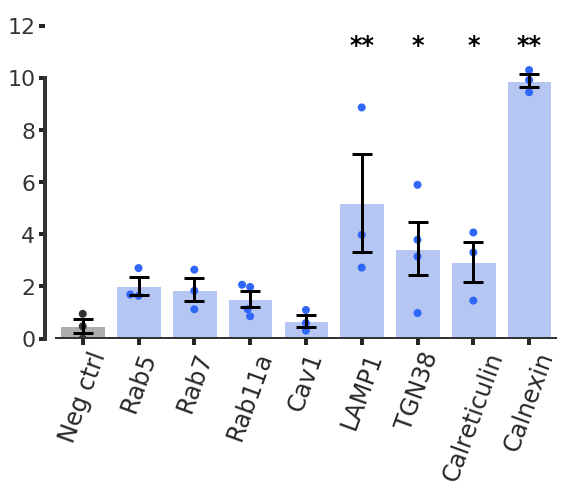

In [21]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

df2plot=organelledf
var="corrected perc"
fig=plt.figure(figsize=(9,6))

order=['Neg ctrl vAchT','Rab5/ TNR Blk, +12',
      'Rab7/ TNR Blk, +12','Rab11a/ TNR Blk, +12','Cav1/ TNR Blk','lamp1/ TNR Blk, +12',
       'TGN38/ TNR Blk, +12',
       'Calreticulin/ TNR Blk, +12, max proj','Calnexin/ TNR Blk, +12, max proj'
       ]

paletteswarm ={'Neg ctrl vAchT':"#333333",
               'Rab5/ TNR Blk, +12':"#2F67F8",
      'Rab7/ TNR Blk, +12':"#2F67F8",
               'Rab11a/ TNR Blk, +12':"#2F67F8",
               'Cav1/ TNR Blk':"#2F67F8",
               'lamp1/ TNR Blk, +12':"#2F67F8",
               'TGN38/ TNR Blk, +12':"#2F67F8",
               'Calreticulin/ TNR Blk, +12, max proj':"#2F67F8",
               'Calnexin/ TNR Blk, +12, max proj':"#2F67F8"}
palette={'Neg ctrl vAchT':"#adadad",
               'Rab5/ TNR Blk, +12':"#abc2fc",
      'Rab7/ TNR Blk, +12':"#abc2fc",
               'Rab11a/ TNR Blk, +12':"#abc2fc",
               'Cav1/ TNR Blk':"#abc2fc",
               'lamp1/ TNR Blk, +12':"#abc2fc",
               'TGN38/ TNR Blk, +12':"#abc2fc",
               'Calreticulin/ TNR Blk, +12, max proj':"#abc2fc",
               'Calnexin/ TNR Blk, +12, max proj':"#abc2fc"}

g=sns.barplot(data=df2plot,y=var,x="Protein"
            ,order=order,palette=palette,ci=None)
g=sns.swarmplot(data=df2plot,y=var,x="Protein",palette=paletteswarm,order=order,size=8)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Protein"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Protein"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.axhline(0, color='#333333',alpha=1,linewidth=4)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
g.grid(False)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
plt.xticks(g.get_xticks(),['Neg ctrl','Rab5',
      'Rab7','Rab11a','Cav1','LAMP1',
       'TGN38','Calreticulin',
       'Calnexin'
       ],
           rotation=70,size=24)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
plt.yticks([0,2,4,6,8,10,12],fontsize=22,color='#333333')
plt.ylim([0,12.5])

plt.text(7, 10.8, "*", ha='center', va='bottom', color=col,size=24, weight='bold')
plt.text(6, 10.8, "*", ha='center', va='bottom', color=col,size=24, weight='bold')

plt.text(5, 10.8, "**", ha='center', va='bottom', color=col,size=24, weight='bold')
plt.text(8, 10.8, "**", ha='center', va='bottom', color=col,size=24, weight='bold')





diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'4b_confocal_colocs.svg', bbox_inches='tight', format='svg')

## Stats (done in Matlab)
- Kruskal Wallis 
- Followed by Tukey
- See csv file for details
- script used: sven.m in exp directory